## Stock Forecasting Using ARIMA

In [2]:
# importing necessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

### Loading and Handling Time Series in Pandas

In [3]:
# load the data
tsla = pd.read_csv("TSLA.csv")
tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [4]:
# identify the data types
tsla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2543 entries, 0 to 2542
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2543 non-null   object 
 1   Open       2543 non-null   float64
 2   High       2543 non-null   float64
 3   Low        2543 non-null   float64
 4   Close      2543 non-null   float64
 5   Adj Close  2543 non-null   float64
 6   Volume     2543 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 139.2+ KB


In [5]:
# decribed data
tsla.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2543.000000,2543.000000,2543.000000,2543.000000,2543.000000,2.543000e+03
mean,221.419438,225.960256,216.733496,221.486453,221.486453,6.140902e+06
std,204.929545,210.866728,198.653835,204.822595,204.822595,5.736859e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,35.259998,35.920000,34.644998,35.224998,35.224998,2.055050e+06
50%,219.000000,222.220001,215.000000,218.789993,218.789993,4.825100e+06
75%,287.264999,294.235001,282.009995,288.955001,288.955001,7.945250e+06
max,1678.949951,1794.989990,1562.000000,1643.000000,1643.000000,6.077560e+07


In [6]:
# identifying the shape of the data
tsla.shape

(2543, 7)

### Time Series Data Structure
Will convert the Date into a datetime for easy resampling of the dataset

In [7]:
# convert the data from object to datetime, to prevent future problems in plotting on a histogram
tsla = pd.read_csv("TSLA.csv", parse_dates=['Date'], index_col="Date")
tsla.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-29,1501.000000,1534.810059,1487.000000,1499.109985,1499.109985,9426900
2020-07-30,1488.000000,1513.239990,1471.000000,1487.489990,1487.489990,7621000
2020-07-31,1515.000000,1517.050049,1420.979980,1430.760010,1430.760010,12247000
2020-08-03,1449.199951,1509.810059,1444.380005,1485.000000,1485.000000,8809300
2020-08-04,1495.010010,1527.410034,1462.000000,1487.000000,1487.000000,8387400


In [8]:
# Check if there is any missing data
tsla.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Looks like we have a clean dataset, with no missing data

In [10]:
# dropping Close column, as we will use the Adjusted Close column for our model
tsla = tsla.drop('Close', axis=1)
tsla = tsla.rename(columns={"Adj Close": "Close"})
tsla

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900
...,...,...,...,...,...
2020-07-29,1501.000000,1534.810059,1487.000000,1499.109985,9426900
2020-07-30,1488.000000,1513.239990,1471.000000,1487.489990,7621000
2020-07-31,1515.000000,1517.050049,1420.979980,1430.760010,12247000


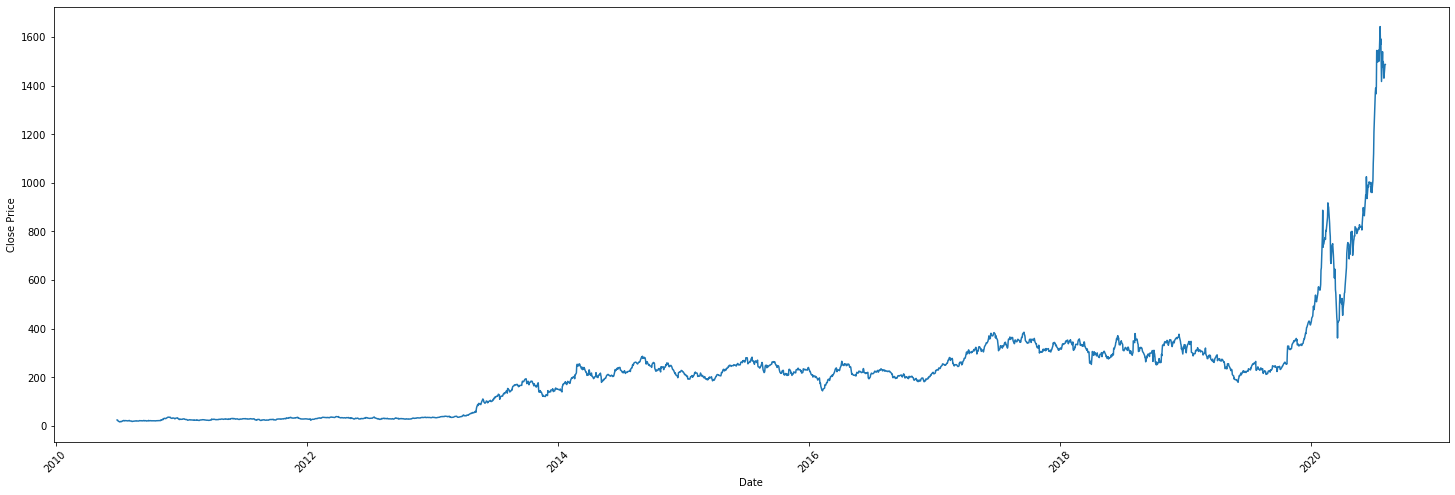

In [11]:
# visualize the data to gain some insight
plt.figure(figsize=(25,8))
plt.plot(tsla.index,'Close', data=tsla)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Call the .corr() method on the apple dataset 
tsla.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.999368,0.999233,0.998593,0.549870
High,0.999368,1.000000,0.998837,0.999162,0.558795
Low,0.999233,0.998837,1.000000,0.999352,0.541838
Close,0.998593,0.999162,0.999352,1.000000,0.549919
Volume,0.549870,0.558795,0.541838,0.549919,1.000000


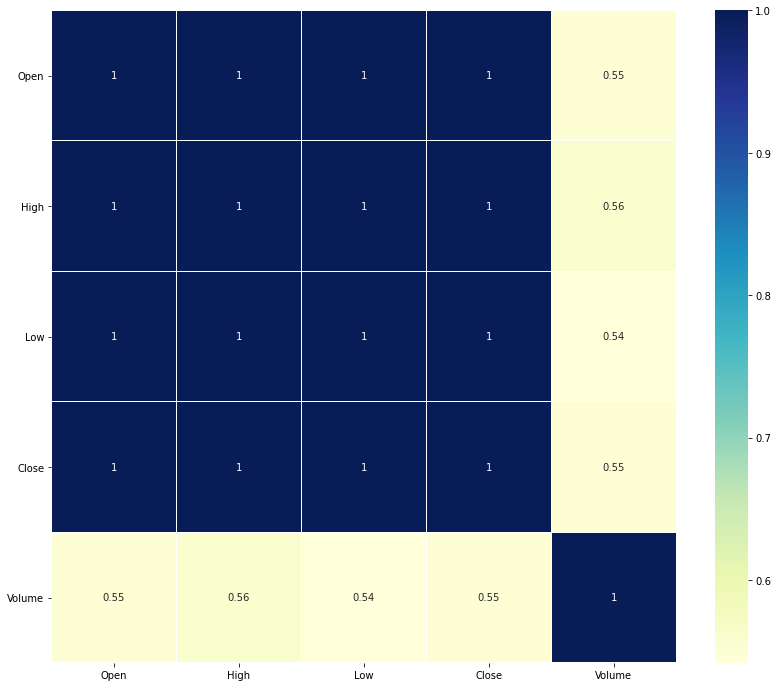

In [14]:
#create the correlation matrix heat map
plt.figure(figsize=(14,12))
sns.heatmap(tsla.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

# EDA

### How to Check Stationarity of our TS data?
We can check stationarity using the following:
Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months.
Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

### Plotting Rolling Statistics

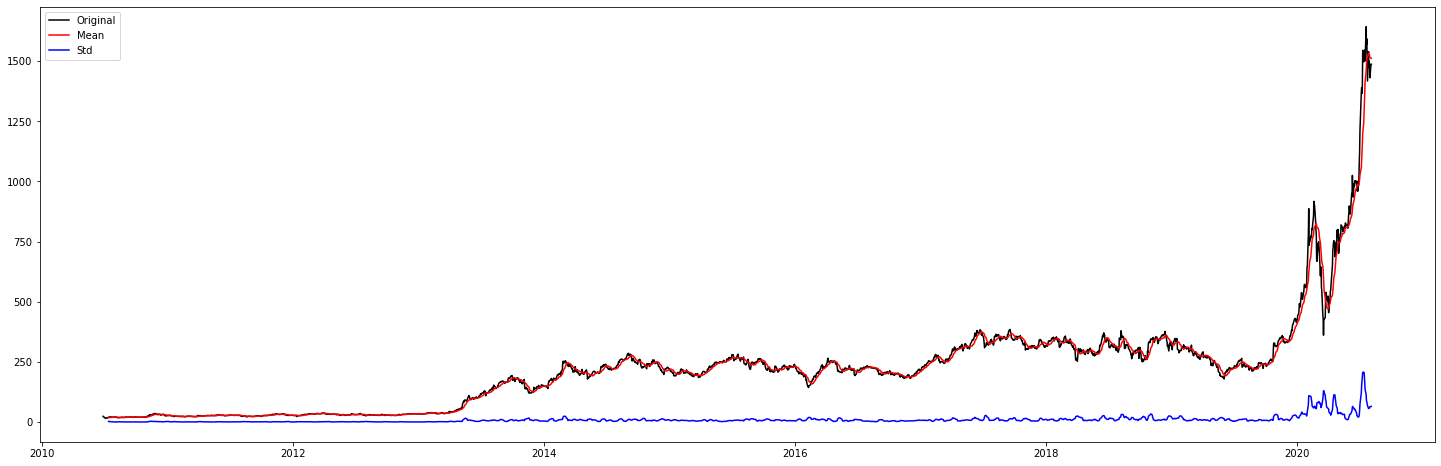

In [15]:
# plot mean and std
plt.figure(figsize=(25,8))
rolmean = tsla['Close'].rolling(window=12).mean()
rolstd = tsla['Close'].rolling(window=12).std()
orig = plt.plot(tsla['Close'], color='black', label='Original')
mean = plt.plot(rolmean, color='red', label='Mean')
std = plt.plot(rolstd, color='blue', label='Std')
plt.legend(loc='best')
plt.title = ("Rolling mean and STD")
plt.show(block=False)

### Dickey-Fuller Test

Null hypothesis in ADF test is that Data is not stationary.
- if Test Statistic < Critical Values => Rejects the null hypothesis.
- if Test Statistic >Critical Values => failed to reject the null hypothesis.

In [16]:
# checking the stationarity of the data by using adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(tsla['Close'])

Results of Dickey-Fuller Test:
Test Statistic                    3.728795
p-value                           1.000000
#Lags Used                       26.000000
Number of Observations Used    2516.000000
Critical Value (1%)              -3.432952
Critical Value (5%)              -2.862689
Critical Value (10%)             -2.567382
dtype: float64


From the results of Dickey-Fuller Test, the p-value is not less than 5%, so we can not reject the null hypothesis that the series is a random walk. As we know that a random walk is a non-stationary series, our next step is to make the series stationary.

### Estimating & Eliminating Trend
One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is an exponential growth and significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. We can first take the differences and than take a log transform to bring the data close to stationarity.

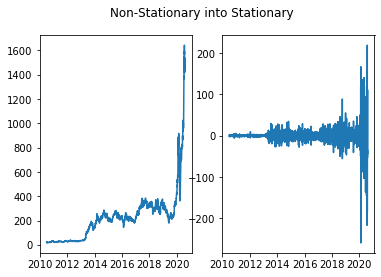

In [17]:
# Calculating and visualizing the difference
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Non-Stationary into Stationary')
# apple data as a non-stationary random walk
ax1.plot(tsla['Close'])
# by computing the first differences, it becomes a stationary white noise process
ax2.plot(tsla['Close'].diff().diff())
plt.show()

So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:
- Aggregation – taking average for a time period like monthly/weekly averages
- Smoothing – taking rolling averages
- Polynomial Fitting – fit a regression model

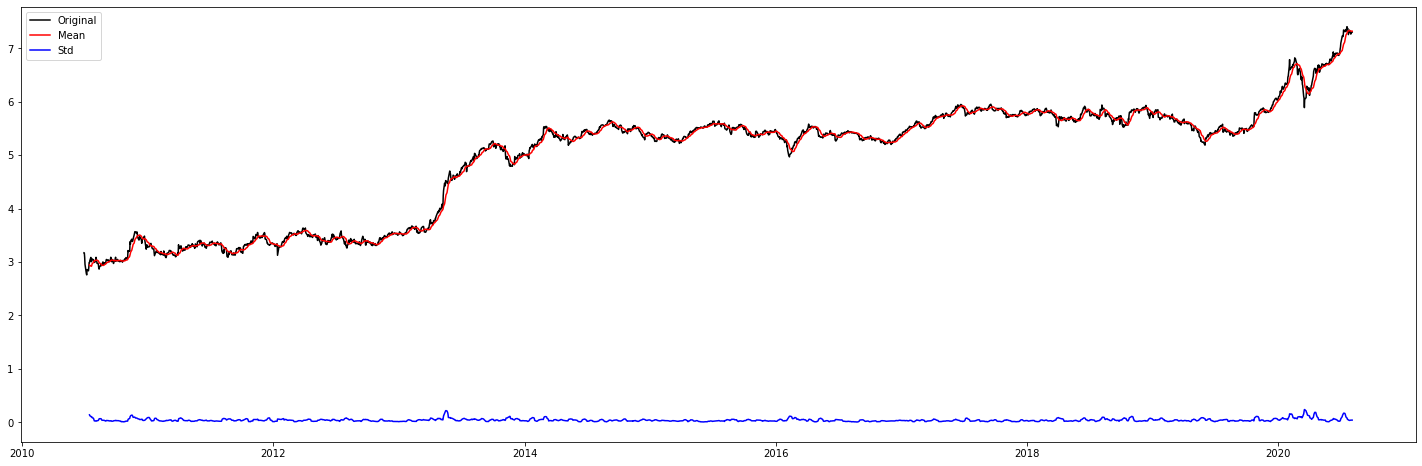

Results of Dicky-Fuller Test:
Test Statistic                   -0.171730
p-value                           0.941809
#Lags Used                        0.000000
Number of Observations Used    2542.000000
Critical Value(1%                -3.432925
Critical Value(5%                -2.862678
Critical Value(10%               -2.567376
dtype: float64


In [18]:
# Taking the log
tslaLogScale = np.log(tsla['Close'])

# Smoothing the data
# Here we can take the average over the past 1 year, i.e. last 12 values.
moving_avg = tslaLogScale.rolling(window = 12).mean()
movingSTD = tslaLogScale.rolling(window=12).std()
plt.figure(figsize=(25,8))
orig = plt.plot(tslaLogScale , color='black', label='Original')
mean = plt.plot(moving_avg, color='red', label='Mean')
std = plt.plot(movingSTD, color='blue', label='Std')
plt.legend(loc='best')
plt.title = ("Rolling mean and STD")
plt.show(block=False)


from statsmodels.tsa.stattools import adfuller
print("Results of Dicky-Fuller Test:")
dftest = adfuller(tslaLogScale, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value(%s' %key] = value
    
print(dfoutput)

By taking only the log of the series we simply eliminate the exponatial growth. Applying the difference and the log at the same time, the transformed series looks stationary.

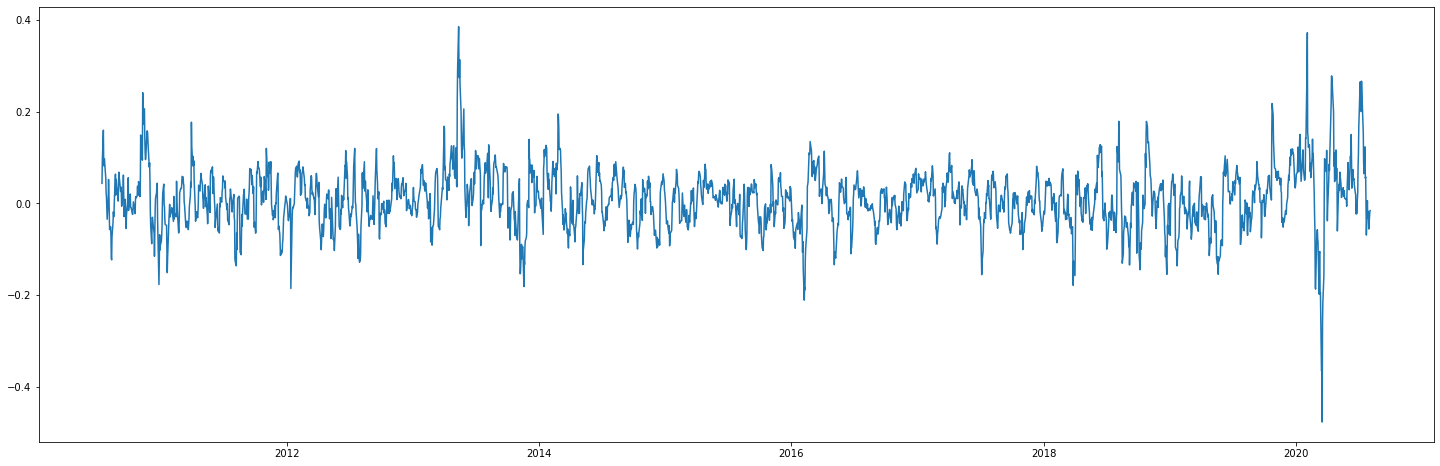

In [19]:
# taking the difference and plotting
tslaLogScaleMinusMA = tslaLogScale - moving_avg
tslaLogScaleMinusMA.dropna(inplace=True)
plt.figure(figsize=(25,8))
plt.plot(tslaLogScaleMinusMA)
plt.show()

In [20]:
# ADF test after taking the log anf difference 
test_stationarity(tslaLogScaleMinusMA)

Results of Dickey-Fuller Test:
Test Statistic                -1.026898e+01
p-value                        4.048413e-18
#Lags Used                     1.100000e+01
Number of Observations Used    2.520000e+03
Critical Value (1%)           -3.432948e+00
Critical Value (5%)           -2.862688e+00
Critical Value (10%)          -2.567381e+00
dtype: float64


This looks like a much better series. However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

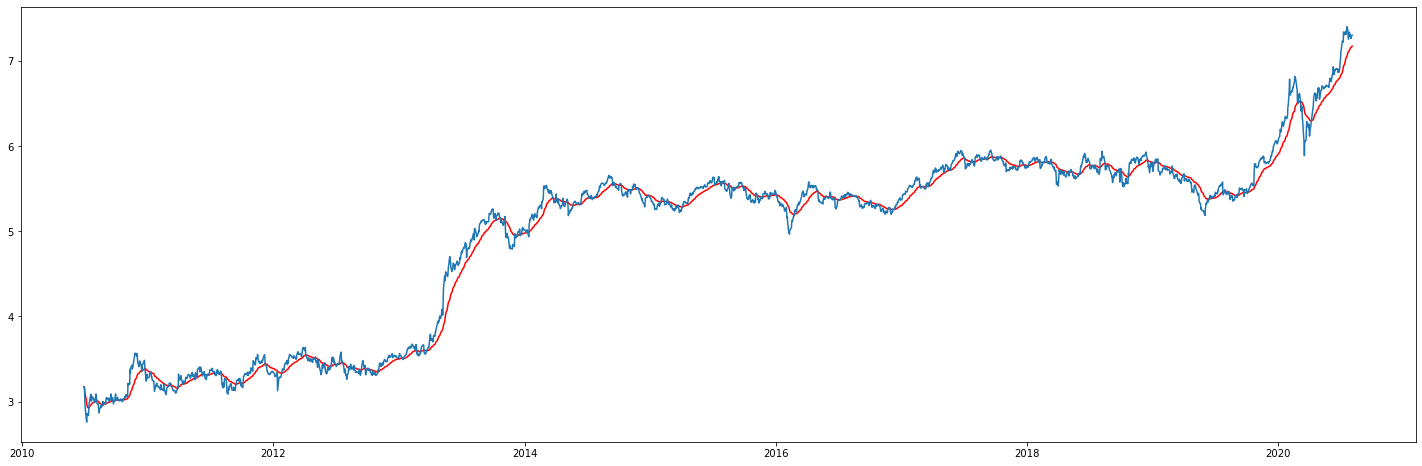

In [21]:
# calculating the weighted moving average
exponentialWeightedAVG = tslaLogScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
tslaLogScaleMinusMovingEWA = tslaLogScale - exponentialWeightedAVG
plt.figure(figsize=(25,8))
plt.plot(exponentialWeightedAVG,  color='red')
plt.plot(tslaLogScale)
plt.show()

In [26]:
# ADF test after calculating the weighted moving average
test_stationarity(tslaLogScaleMinusMovingEWA)

Results of Dickey-Fuller Test:
Test Statistic                -8.367287e+00
p-value                        2.721301e-13
#Lags Used                     0.000000e+00
Number of Observations Used    2.542000e+03
Critical Value (1%)           -3.432925e+00
Critical Value (5%)           -2.862678e+00
Critical Value (10%)          -2.567376e+00
dtype: float64


The ADF test now has generated a great output where the test statistic value is smaller than 1% Critical vale, which allows us the flexibility of rejecting the null hypothesis. The data now is stationary, which is essitial for further analysis.

In [22]:
# updating the 'Close' column with the stationarized data
tsla['Close']=tslaLogScaleMinusMovingEWA

In [24]:
#appleLogScaleMinusMovingEWA.head()
tsla.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29,19.000000,25.00,17.540001,0.000000,18766300
2010-06-30,25.790001,30.42,23.299999,-0.001221,17187100
2010-07-01,25.000000,25.92,20.270000,-0.053684,8218800
2010-07-02,23.000000,23.10,18.709999,-0.136850,5139800
2010-07-06,20.000000,20.00,15.830000,-0.242440,6866900


Next steps would be generating the technical indicators we will use for the ARIMA model.